# Import libraries

In [1]:
import os, sys
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
# For plotting heap map of confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
# For transfer learning
from tensorflow.keras.applications import ResNet50
# To plot training history
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Mount Google Drive

In [2]:
# Access Google Drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# Function to load training data

In [0]:
def load_dataset(train_folder, image_height, image_width, channels):

  # gets list of .jpg in folder
  jpg_files = [f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f)) and f.endswith('.jpg')]

  image_files = []
  labels = []

  for file in jpg_files:
    # Files starting with H or N are non-PM: class 0
    if file.startswith('H') or file.startswith('N'):
      image_files.append(file)
      labels.append(0)
    # Files starting with P are PM: class 1
    elif file.startswith('P'):
      image_files.append(file)
      labels.append(1)
    else:
      print("Wrong label, imagen will be discarded.")
    
  images = np.ndarray(shape=(len(image_files), image_height, image_width, channels),
                      dtype=np.float32)
  idx = 0

  for file in image_files:
    image = load_img(train_folder + "/" + file, target_size=(image_height, image_width))
    image_array = img_to_array(image)
    images[idx] = image_array
    idx += 1

  # Convert label list to numpy array
  labels = np.array(labels)

  return images, labels

# Function to preprocess images



In [0]:
def preprocess_images(X_train, y_train, X_val, y_val, batch_size):

  # Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches)
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  # Generator for training set
  train_generator = train_datagen.flow(X_train,
                            y_train,
                            batch_size=batch_size)

  # No data augmentation for validation set
  val_datagen = ImageDataGenerator(rescale=1./255)
  
  # Generator for validation set
  validation_generator = val_datagen.flow(X_val,
                                 y_val,
                                 batch_size=batch_size,
                                 shuffle=False)

  return train_generator, validation_generator

# Function to create and compile model

In [29]:
def get_model(input_shape, loss, optimizer, metrics, n_classes):

  restnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
  output = restnet.layers[-1].output
  output = keras.layers.Flatten()(output)
  restnet = Model(restnet.input, outputs=output)
  for layer in restnet.layers:
      layer.trainable = False

  model = Sequential()
  model.add(restnet)
  model.add(Dense(512, activation='relu', input_dim=input_shape))
  model.add(Dropout(0.3))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid')) 

  model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=metrics)

  model.summary()

  return model
'''
  resnet50_model = ResNet50(weights='imagenet', 
                      include_top=False,
                      input_shape=input_shape,
                      classes=n_classes)
  avg = GlobalAveragePooling2D()(resnet50_model.output)
  output = Dense(1, activation='sigmoid')(avg)
  #output = Dense(2, activation='softmax')(avg)
  model = Model(inputs=resnet50_model.input, outputs=output)

  # We're not training ResNet50 layers, only top layers
  for layer in resnet50_model.layers:
    layer.trainable = False  

  # Compile
  model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

  model.summary()

  return model
'''

"\n  resnet50_model = ResNet50(weights='imagenet', \n                      include_top=False,\n                      input_shape=input_shape,\n                      classes=n_classes)\n  avg = GlobalAveragePooling2D()(resnet50_model.output)\n  output = Dense(1, activation='sigmoid')(avg)\n  #output = Dense(2, activation='softmax')(avg)\n  model = Model(inputs=resnet50_model.input, outputs=output)\n\n  # We're not training ResNet50 layers, only top layers\n  for layer in resnet50_model.layers:\n    layer.trainable = False  \n\n  # Compile\n  model.compile(loss=loss,\n              optimizer=optimizer,\n              metrics=metrics)\n\n  model.summary()\n\n  return model\n"

# Variables

In [0]:
# Number of classes
n_classes = 2
# Size of images
image_height, image_width = (256, 256)
# Channels of images: 3 for RGB
channels = 3
input_shape = (image_height, image_width, channels)
# Path to images for training
train_folder = '/gdrive/My Drive/TFG Daniel López Robles/train/'
# Extension of the images of our dataset
file_extesion = '.jpg'
# Number of images for training
n_observations = len([f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f)) and f.endswith('.jpg')])
# Batch size for ImageDataGenerators
batch_size = 32

# Variables for compiling model
loss = 'binary_crossentropy'
#loss = 'categorical_crossentropy'
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = [keras.metrics.BinaryAccuracy(name='accuracy')]

# Number of folds for stratified k-fold cross validation
CVfolds = 5

# Path to save models
models_path = '/gdrive/My Drive/TFG Daniel López Robles/modelos/'

# Variables for training (model.fit)
steps_per_epoch = ((n_observations // CVfolds) * (CVfolds-1)) // batch_size
epochs = 50
#validation_steps = (n_observations // CVfolds) // batch_size
# callbacks
#checkpoint_cb = keras.callbacks.ModelCheckpoint(models_path+'cnn_cross-validation_checkpoint_20200514_1739.h5',
#                                                save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1,
                              patience=2, 
                              min_lr=0.001)
callbacks_list = [early_stopping_cb, reduce_lr]

# 1. Load dataset

In [7]:
# Load dataset
images, labels = load_dataset(train_folder, image_height, image_width, channels)
print("images shape: {} \nlabels shape: {}".format(images.shape, labels.shape))

images shape: (400, 256, 256, 3) 
labels shape: (400,)


## Additional preprocessing for ResNet50

---




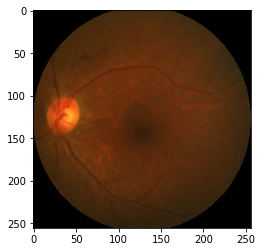

In [8]:
# Checking an image before processing
plt.imshow(tf.keras.preprocessing.image.array_to_img(images[0,:,:,:]))

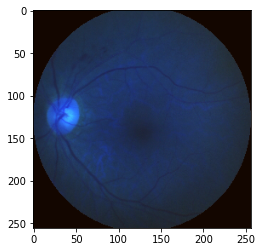

In [9]:
# Processing for VGG16
images = keras.applications.resnet50.preprocess_input(images)

# Checking an image after processing
plt.imshow(tf.keras.preprocessing.image.array_to_img(images[0,:,:,:]))

In [28]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output=output)
for layer in restnet.layers:
    layer.trainable = False

model = Sequential()
model.add(restnet)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=2e-5),
            metrics=metrics)

model.summary()

TypeError: ignored

# 2. Create and train model

Fold: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 131072)            23587712  
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 90,960,257
Trainable params: 67,372,545
Non-trainable params: 23,587,712
___________________________

KeyboardInterrupt: ignored

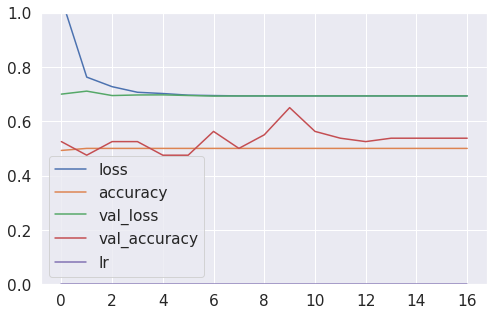

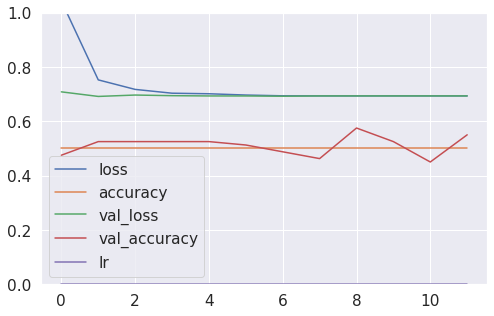

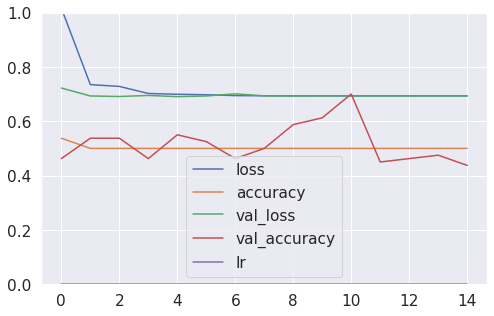

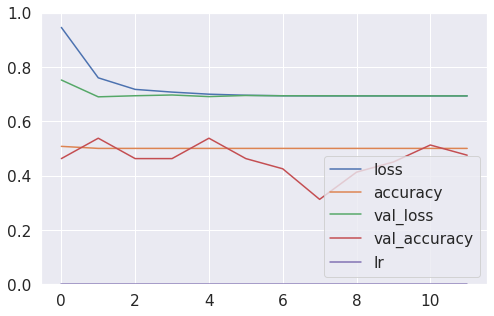

In [30]:
# Matrix for saving scores of model.evaluate for each fold: 
#   rows = number of folds
#   columns = loss + metrics
scores = np.zeros((CVfolds, len(metrics)+1))

# Matrix for saving ground truth and prediction for each fold
folds_y_val = np.zeros((CVfolds, n_observations // CVfolds))
folds_y_pred = np.zeros((CVfolds, n_observations // CVfolds))
folds_y_proba = np.zeros((CVfolds, n_observations // CVfolds))

skf = StratifiedKFold(n_splits=CVfolds)

for fold, (train_index, val_index) in enumerate(skf.split(images, labels)):
  K.clear_session()
  print("Fold: {}".format(fold+1))
  X_train, X_val = images[train_index], images[val_index]
  y_train, y_val = labels[train_index], labels[val_index]

  y_train = to_categorical(y_train)
  #y_val_cat = to_categorical(y_val)
    
  train_generator, validation_generator = preprocess_images(X_train, y_train, X_val, y_val, batch_size)
  #train_generator, validation_generator = preprocess_images(X_train, y_train, X_val, y_val_cat, batch_size)

  # Create and compile model
  model = get_model(input_shape, loss, optimizer, metrics, n_classes)

  # Train model
  history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator,
    #validation_steps=validation_steps,
    callbacks=callbacks_list)
  
  # Save metrics of model.evaluate for this fold in a row of scores matrix
  scores[fold] = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
  #scores[fold] = model.evaluate(X_val, y_val_cat, batch_size=batch_size, verbose=0)
  
  # Save ground truth and predictions for this fold
  folds_y_val[fold] = y_val
  #folds_y_pred[fold] = model.predict(X_val, batch_size=batch_size, steps=validation_steps).flatten()
  #folds_y_pred[fold] = model.predict(X_val, batch_size=batch_size).flatten()
  y_pred = model.predict(X_val, batch_size=batch_size)
  folds_y_pred[fold] = np.argmax(y_pred, axis=1)
  folds_y_proba[fold] = y_pred.flatten()

  print("===================== SCORES ======================\n{}\n{}\n===================================================".format(model.metrics_names, scores[fold]))

  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)
  plt.show

  #model.save(models_path+'cnn1_fold_'+str(fold)+'_20200515.h5')
  #np.save(models_path+'cnn1_fold_'+str(fold)+'_20200515.npy', history.history)

# Print results
# Means and standard deviation for model's metrics
print("======================== MODEL MEAN ===========================")
print("{}\n{}".format(model.metrics_names, np.mean(scores, axis=0)))
print("=================== MODEL STANDARD DEVIATION ==================")
print("{}\n{}\n\n".format(model.metrics_names, np.std(scores, axis=0)))

# For displaying metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve

accuracy_per_fold = np.zeros((CVfolds))
precision_per_fold = np.zeros((CVfolds))
recall_per_fold = np.zeros((CVfolds))
roc_auc_per_fold = np.zeros((CVfolds))

for fold in range(1, CVfolds+1):
  accuracy_per_fold[fold-1] = accuracy_score(folds_y_val[fold-1], folds_y_pred[fold-1])
  precision_per_fold[fold-1] = precision_score(folds_y_val[fold-1], folds_y_pred[fold-1], average='macro')
  recall_per_fold[fold-1] = recall_score(folds_y_val[fold-1], folds_y_pred[fold-1], average='macro')
  roc_auc_per_fold[fold-1] = roc_auc_score(folds_y_val[fold-1], folds_y_proba[fold-1], average='macro')

print("Accuracy:\n\tMean: {:.3f}\n\tStandard deviation: {:.3f}".format(np.mean(accuracy_per_fold), np.std(accuracy_per_fold)))
print("Precision:\n\tMean: {:.3f}\n\tStandard deviation: {:.3f}".format(np.mean(precision_per_fold), np.std(precision_per_fold)))
print("Recall:\n\tMean: {:.3f}\n\tStandard deviation: {:.3f}\n".format(np.mean(recall_per_fold), np.std(recall_per_fold)))
print("ROC AUC:\n\tMean: {:.3f}\n\tStandard deviation: {:.3f}\n".format(np.mean(roc_auc_per_fold), np.std(roc_auc_per_fold)))

for fold in range(1, CVfolds+1):
  print("================ Fold {} =====================".format(fold))
  print(classification_report(folds_y_val[fold-1], folds_y_pred[fold-1], target_names=['normal', 'pm']))

  # Scores for this fold
  print("{}\n{}".format(model.metrics_names, scores[fold-1]))

  # Confusion matrix
  df_cm = pd.DataFrame(tf.math.confusion_matrix(folds_y_val[fold-1], folds_y_pred[fold-1]).numpy(), index=['normal', 'pm'], columns=['normal', 'pm'])
  plt.figure(figsize=(4,3))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, cmap='RdYlGn', annot=True, annot_kws={"size": 14}) # font size
  plt.show()
  
  fpr, tpr, thresholds = roc_curve(folds_y_val[fold-1], folds_y_proba[fold-1])
  plt.plot(fpr, tpr, linewidth=2)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.ylabel('True Positive Rate (Recall)')
  plt.xlabel('False Positive Rate')
  plt.show()

# 3. Print metrics and confusion matrices

Accuracy:
	Mean: 0.910
	Standard deviation: 0.069
Precision:
	Mean: 0.924
	Standard deviation: 0.049
Recall:
	Mean: 0.915
	Standard deviation: 0.066

ROC AUC:
	Mean: 0.982
	Standard deviation: 0.015

================ Fold 1 =====================
              precision    recall  f1-score   support

      normal       0.69      1.00      0.82        38
          pm       1.00      0.60      0.75        42

    accuracy                           0.79        80
   macro avg       0.85      0.80      0.78        80
weighted avg       0.85      0.79      0.78        80

ROC AUC score: 0.9642857142857143


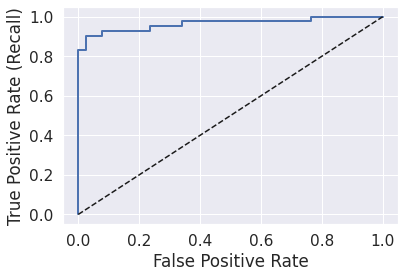

================ Fold 2 =====================
              precision    recall  f1-score   support

      normal       0.84      1.00      0.92        38
          pm       1.00      0.83      0.91        42

    accuracy                           0.91        80
   macro avg       0.92      0.92      0.91        80
weighted avg       0.93      0.91      0.91        80

ROC AUC score: 0.9837092731829574


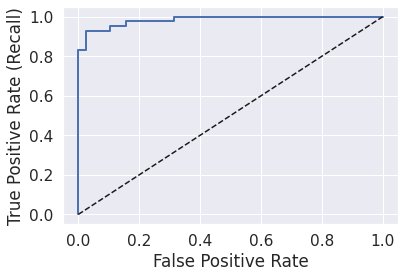

================ Fold 3 =====================
              precision    recall  f1-score   support

      normal       0.97      1.00      0.99        37
          pm       1.00      0.98      0.99        43

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

ROC AUC score: 1.0


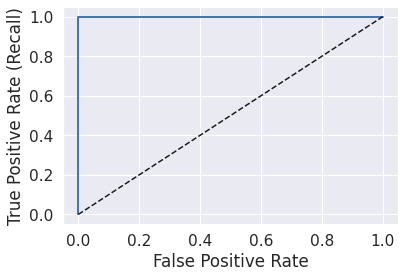

================ Fold 4 =====================
              precision    recall  f1-score   support

      normal       0.84      0.97      0.90        37
          pm       0.97      0.84      0.90        43

    accuracy                           0.90        80
   macro avg       0.91      0.91      0.90        80
weighted avg       0.91      0.90      0.90        80

ROC AUC score: 0.9660590823381521


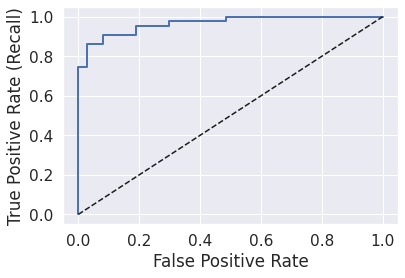

================ Fold 5 =====================
              precision    recall  f1-score   support

      normal       0.93      1.00      0.96        37
          pm       1.00      0.93      0.96        43

    accuracy                           0.96        80
   macro avg       0.96      0.97      0.96        80
weighted avg       0.97      0.96      0.96        80

ROC AUC score: 0.9974858579509743


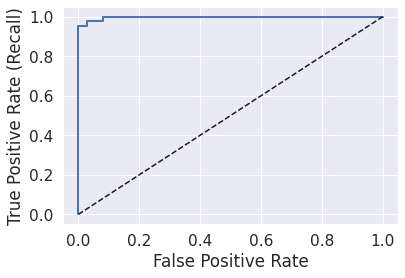

In [0]:
# For displaying metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve

accuracy_per_fold = np.zeros((CVfolds))
precision_per_fold = np.zeros((CVfolds))
recall_per_fold = np.zeros((CVfolds))
roc_auc_per_fold = np.zeros((CVfolds))

for fold in range(1, CVfolds+1):
  accuracy_per_fold[fold-1] = accuracy_score(folds_y_val[fold-1], folds_y_pred[fold-1])
  precision_per_fold[fold-1] = precision_score(folds_y_val[fold-1], folds_y_pred[fold-1], average='macro')
  recall_per_fold[fold-1] = recall_score(folds_y_val[fold-1], folds_y_pred[fold-1], average='macro')
  roc_auc_per_fold[fold-1] = roc_auc_score(folds_y_val[fold-1], folds_y_proba[fold-1], average='macro')

print("Accuracy:\n\tMean: {:.3f}\n\tStandard deviation: {:.3f}".format(np.mean(accuracy_per_fold), np.std(accuracy_per_fold)))
print("Precision:\n\tMean: {:.3f}\n\tStandard deviation: {:.3f}".format(np.mean(precision_per_fold), np.std(precision_per_fold)))
print("Recall:\n\tMean: {:.3f}\n\tStandard deviation: {:.3f}\n".format(np.mean(recall_per_fold), np.std(recall_per_fold)))
print("ROC AUC:\n\tMean: {:.3f}\n\tStandard deviation: {:.3f}\n".format(np.mean(roc_auc_per_fold), np.std(roc_auc_per_fold)))

for fold in range(1, CVfolds+1):
  print("================ Fold {} =====================".format(fold))
  print(classification_report(folds_y_val[fold-1], folds_y_pred[fold-1], target_names=['normal', 'pm']))
  print("ROC AUC score: {}".format(roc_auc_score(folds_y_val[fold-1], folds_y_proba[fold-1], average='macro')))

  fpr, tpr, thresholds = roc_curve(folds_y_val[fold-1], folds_y_proba[fold-1])
  plt.plot(fpr, tpr, linewidth=2)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.ylabel('True Positive Rate (Recall)')
  plt.xlabel('False Positive Rate')
  plt.show()